## AI-Based Job Matching and Compatibility Analysis System

 This system analyzes a candidate's resume and matches it against job postings using semantic similarity, bidirectional skill gap analysis, and dynamic fit classification.

## System Architecture

The system consists of:
1. Resume Processing Layer
2. Job Filtering Layer
3. Semantic Retrieval Layer
4. Bidirectional Skill Analysis
5. Scoring and Classification Layer
6. Explainable Output Generation

In [1]:
# Importing Libraries
!pip install sentence-transformers
!pip install scikit-learn
!pip install requests
!pip install beautifulsoup4
!pip install PyPDF2
from PyPDF2 import PdfReader
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

### Step 1: Dataset Loading

In [2]:
# Load dataset
import pandas as pd
df = pd.read_csv("dataset.csv")
df_unchanged = df
print(df.shape)
print(df.columns.tolist())
df.head()

(123849, 31)
['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips']


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [3]:
# Removing rows of null values in description, title column
df = df.dropna(subset=["description", "title"])
print("After dropping missing:", df.shape)

After dropping missing: (123842, 31)


In [4]:
# Removing duplicate jobs
before = df.shape[0]
df = df.drop_duplicates(subset=["title", "description"])
after = df.shape[0]

print("Removed duplicates:", before - after)
print("Remaining rows:", after)

Removed duplicates: 12944
Remaining rows: 110898


### Step 2: Resume Processing and Skill Extraction

In [5]:
!pip install pdfplumber

In [6]:
# Extracting text from pdf
import pdfplumber
with pdfplumber.open("resume.pdf") as pdf:
    resume_text = ""
    for page in pdf.pages:
        resume_text += page.extract_text() + "\n"

print(resume_text[:1000])
resume_text_lower = resume_text.lower()

.
FIRST LAST
San Francisco, California 94109 | (480) 123‐5689 | sampleresume@gmail.com | linkedin.com/in/sampleresume
SUMMARY
An analytical and results‐driven software engineer with experience in application development, scripting and coding,
automation, web application design, product testing and deployment, UI testing, and requirements gathering. Proven
aptitude for implementing innovative solutions to streamline and automate processes, enhance efficiency, improve
customer satisfaction, and achieve financial savings.
E D U C A TI O N
UNIVERSITY OF ARIZONA, Tucson, Arizona
M.S., Computer Science, 2012
B.S.B.A., Management Information Systems, 2011
TECH N ICA L SK ILLS
JavaScript: ReactJS, AngularJS 1.x, ExpressJS, NodeJS, jQuery, HTML/CSS
Mobile: React Native, ExponentJS
Java: Spring, Maven
Databases: MongoDB, SQL
Build/Deploy: Docker, Tomcat, Grunt, Heroku, CircleCI
EXPERIEN CE
WALMART, INC., Bentonville, Arkansas
Programmer Analyst, Call Center Engineering Team, 2011‐2016
 Architec

In [7]:
# Using keywords to understand the job domain of applicant and extracting skills in resume
skill_keywords = [
    # Programming
    "python", "java", "c++", "sql", "javascript",
    
    # AI / ML
    "machine learning", "deep learning", "nlp",
    "computer vision", "data science",
    
    # Web
    "react", "node", "html", "css", "django", "flask",
    
    # Cloud / DevOps
    "aws", "azure", "docker", "kubernetes",
    
    # Blockchain / Cyber
    "blockchain", "solidity", "cybersecurity",
    
    # Data tools
    "pandas", "numpy", "power bi", "scikit-learn"
]
resume_skills = []
for skill in skill_keywords:
    if skill in resume_text_lower:
        resume_skills.append(skill)

print("Extracted Resume Skills:")
print(resume_skills)

Extracted Resume Skills:
['java', 'sql', 'javascript', 'react', 'node', 'html', 'css', 'docker']


In [8]:
# Retrieving applicant experience level

resume_experience_level = "Entry-Level"
if "senior" in resume_text_lower:
    resume_experience_level = "Senior"
elif "lead" in resume_text_lower:
    resume_experience_level = "Senior"
elif "intern" in resume_text_lower or "student" in resume_text_lower:
    resume_experience_level = "Entry-Level"

print("Resume Experience Level:", resume_experience_level)

Resume Experience Level: Entry-Level


In [9]:
# Lowering datasize for compute efficiency
df_sample = df.sample(n=20000, random_state=42)
print("Sample size:", df_sample.shape)

Sample size: (20000, 31)


### Step 3: Semantic Embedding and Similarity Computation

In [10]:
# Load a pre-trained sentence transformer model and convert the resume text into a semantic embedding vector.
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
resume_embedding = model.encode(resume_text)

print(resume_embedding.shape)  # Displays the dimensionality of the generated embedding

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


(384,)


In [11]:
# Job Embeddings
job_texts = df_sample["description"].tolist()
job_embeddings = model.encode(job_texts, show_progress_bar=True)
print(type(job_embeddings))
print(len(job_embeddings))

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
20000


### Step 4: Cosine Similarity

In [12]:
# Compute cosine similarity between the resume embedding and all job embeddings to measure semantic relevance scores.
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarities = cosine_similarity(
    [resume_embedding],
    job_embeddings
)[0]

print("Similarity vector shape:", similarities.shape)


Similarity vector shape: (20000,)


In [13]:
# Attach similarity scores to dataframe
df_sample["semantic_score"] = similarities

# Sort jobs by semantic score (highest first)
top_jobs = df_sample.sort_values(
    by="semantic_score",
    ascending=False
)
print("Top jobs prepared.")

Top jobs prepared.


In [14]:
print(df_sample.columns.tolist())

['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code', 'fips', 'semantic_score']


In [15]:
print(top_jobs["skills_desc"].head(5))

47712     NaN
64346     NaN
41713     NaN
102911    NaN
9506      NaN
Name: skills_desc, dtype: object


In [16]:
for _, row in top_jobs.head(10).iterrows():
    print("Title:", row["title"])
    print("Company:", row["company_name"])
    print("Location:", row["location"])
    print("Semantic Score:", round(row["semantic_score"], 3))
    print("Apply Link:", row["application_url"])
    print("-" * 80)

Title: React UI Developer
Company: System Soft Technologies
Location: Dallas, TX
Semantic Score: 0.608
Apply Link: nan
--------------------------------------------------------------------------------
Title: Full Stack Engineer
Company: TSR Consulting Services, Inc.
Location: Tampa, FL
Semantic Score: 0.592
Apply Link: nan
--------------------------------------------------------------------------------
Title: Javascript Developer
Company: Centraprise
Location: Richmond, VA
Semantic Score: 0.587
Apply Link: nan
--------------------------------------------------------------------------------
Title: Principal IT Architect
Company: NextEra Energy Resources
Location: Palm Beach Gardens, FL
Semantic Score: 0.584
Apply Link: https://jobs.nexteraenergy.com/job/Palm-Beach-Gardens-Principal-IT-Architect-FL-33410/1157167000/
--------------------------------------------------------------------------------
Title: Technical Lead
Company: CodeMonk
Location: United States
Semantic Score: 0.568
Apply Li

### Step 5: Resume → Job Skill Coverage

In [17]:
top_jobs["skills_desc"] = top_jobs["skills_desc"].fillna("").str.lower()

In [18]:
# Compute resume to job skill coverage by checking how many resume skills appear in the job's listed skill description.
def compute_skill_match(job_skill_text, resume_skills):
    if not job_skill_text:
        return 0, [], resume_skills  # No skills listed in job
    
    matched = []
    for skill in resume_skills:
        if skill in job_skill_text:
            matched.append(skill)
    
    # Calculate coverage ratio (matched resume skills / total resume skills)
    coverage = len(matched) / len(resume_skills) if resume_skills else 0
    
    # Identify resume skills not utilized in the job
    missing = [s for s in resume_skills if s not in matched]
    
    return coverage, matched, missing

# Apply skill matching across top jobs
top_jobs["skill_coverage"], top_jobs["matched_skills"], top_jobs["missing_skills"] = zip(
    *top_jobs["skills_desc"].apply(lambda x: compute_skill_match(x, resume_skills))
)

# Ensure coverage is treated as numeric
top_jobs["skill_coverage"] = top_jobs["skill_coverage"].astype(float)

# Preview skill coverage results
print(top_jobs[["title", "skill_coverage"]].head(10))
def compute_skill_match(job_skill_text, resume_skills):
    if not job_skill_text:
        return 0, [], resume_skills
    
    matched = []
    for skill in resume_skills:
        if skill in job_skill_text:
            matched.append(skill)
    coverage = len(matched) / len(resume_skills) if resume_skills else 0
    missing = [s for s in resume_skills if s not in matched]
    return coverage, matched, missing

top_jobs["skill_coverage"], top_jobs["matched_skills"], top_jobs["missing_skills"] = zip(
    *top_jobs["skills_desc"].apply(lambda x: compute_skill_match(x, resume_skills))
)
top_jobs["skill_coverage"] = top_jobs["skill_coverage"].astype(float)

print(top_jobs[["title", "skill_coverage"]].head(10))

                                      title  skill_coverage
47712                    React UI Developer           0.000
64346                   Full Stack Engineer           0.000
41713                  Javascript Developer           0.000
102911               Principal IT Architect           0.000
9506                         Technical Lead           0.000
106096  Senior Full-Stack Software Engineer           0.000
10610                     Sr. Java Engineer           0.000
41361           Senior Performance Engineer           0.000
85204                   Mainframe Developer           0.000
66823             Java Full Stack Developer           0.125
                                      title  skill_coverage
47712                    React UI Developer           0.000
64346                   Full Stack Engineer           0.000
41713                  Javascript Developer           0.000
102911               Principal IT Architect           0.000
9506                         Technical L

In [19]:
# Removing skills description rows with null values
print(top_jobs["skills_desc"].isna().sum())
print((top_jobs["skills_desc"] == "").sum())

0
19616


In [20]:
top_jobs["description_lower"] = top_jobs["description"].fillna("").astype(str).str.lower()
print(type(top_jobs["description_lower"].iloc[0]))
print(top_jobs["description_lower"].iloc[0][:200])

<class 'str'>
position summary:the ux developer will be responsible for developing the front-ends for both customer-facing and internal applications
essential functions• design, develop, and test user interfaces fo


In [21]:
for i, (_, row) in enumerate(top_jobs.head(10).iterrows(), 1):
    print(f"Rank {i}")
    print("JobId:", row["job_id"])
    print("Title:", row["title"])
    print("Company:", row["company_name"])
    print("Location:", row["location"])
    print("Semantic Score:", round(row["semantic_score"], 3))
    print("Skill Coverage:", round(row["skill_coverage"], 3))
    print("Matched Skills:", ", ".join(row["matched_skills"]))
    print("Missing Skills:", ", ".join(row["missing_skills"]))
    print("Apply Link:", row["application_url"] if pd.notna(row["application_url"]) else row["job_posting_url"])
    print("=" * 80)

Rank 1
JobId: 3901169389
Title: React UI Developer
Company: System Soft Technologies
Location: Dallas, TX
Semantic Score: 0.608
Skill Coverage: 0.0
Matched Skills: 
Missing Skills: java, sql, javascript, react, node, html, css, docker
Apply Link: https://www.linkedin.com/jobs/view/3901169389/?trk=jobs_biz_prem_srch
Rank 2
JobId: 3902357961
Title: Full Stack Engineer
Company: TSR Consulting Services, Inc.
Location: Tampa, FL
Semantic Score: 0.592
Skill Coverage: 0.0
Matched Skills: 
Missing Skills: java, sql, javascript, react, node, html, css, docker
Apply Link: https://www.linkedin.com/jobs/view/3902357961/?trk=jobs_biz_prem_srch
Rank 3
JobId: 3899526564
Title: Javascript Developer
Company: Centraprise
Location: Richmond, VA
Semantic Score: 0.587
Skill Coverage: 0.0
Matched Skills: 
Missing Skills: java, sql, javascript, react, node, html, css, docker
Apply Link: https://www.linkedin.com/jobs/view/3899526564/?trk=jobs_biz_prem_srch
Rank 4
JobId: 3905287272
Title: Principal IT Architec

### Step 6: Job → Resume Skill Coverage

In [22]:
# Extract skills mentioned in each job description by checking which known skill keywords appear in the text.
def extract_job_skills(job_text, skill_keywords):
    if not isinstance(job_text, str):
        return []
    
    job_text = job_text.lower()
    found_skills = []
    
    for skill in skill_keywords:
        if skill in job_text:
            found_skills.append(skill)
    
    return found_skills

# Create a new column listing skills required for each job
top_jobs["job_skills"] = top_jobs["description_lower"].apply(
    lambda x: extract_job_skills(x, skill_keywords))
print(top_jobs[["title", "job_skills"]].head(5))

# Check how many required job skills the candidate has
def compute_job_coverage(job_skills, resume_skills):
    if not job_skills:
        return 0.0, []
    
    matched = [skill for skill in job_skills if skill in resume_skills]
    missing_required = [skill for skill in job_skills if skill not in resume_skills]
    
    coverage = len(matched) / len(job_skills)
    
    return coverage, missing_required   

# Apply job coverage calculation
top_jobs["job_coverage"], top_jobs["missing_required_skills"] = zip(
    *top_jobs["job_skills"].apply(
        lambda x: compute_job_coverage(x, resume_skills)
    )
)
top_jobs["dual_score"] = (
    top_jobs["skill_coverage"] + top_jobs["job_coverage"]
) / 2
print(top_jobs[["title", "skill_coverage", "job_coverage", "dual_score"]].head(10))

                         title  \
47712       React UI Developer   
64346      Full Stack Engineer   
41713     Javascript Developer   
102911  Principal IT Architect   
9506            Technical Lead   

                                               job_skills  
47712                [java, javascript, react, html, css]  
64346                             [java, sql, kubernetes]  
41713           [java, sql, javascript, react, html, css]  
102911  [java, sql, javascript, html, css, aws, kubern...  
9506             [java, sql, javascript, node, html, css]  
                                      title  skill_coverage  job_coverage  \
47712                    React UI Developer           0.000      1.000000   
64346                   Full Stack Engineer           0.000      0.666667   
41713                  Javascript Developer           0.000      1.000000   
102911               Principal IT Architect           0.000      0.714286   
9506                         Technical Lead       

In [23]:
# Stage: Dual Compatibility

In [24]:
for i, (_, row) in enumerate(top_jobs.head(10).iterrows(), 1):
    
    resume_percent = round(row["skill_coverage"] * 100, 1)
    job_percent = round(row["job_coverage"] * 100, 1)
    semantic_percent = round(row["semantic_score"] * 100, 1)
    dual_percent = round(((row["skill_coverage"] + row["job_coverage"]) / 2) * 100, 1)
    
    print(f"\nRank {i}")
    print("JobId:", row["job_id"])
    print("Title:", row["title"])
    print("Company:", row["company_name"])
    print("Location:", row["location"])
    print("Apply Link:", row["application_url"] if pd.notna(row["application_url"]) else row["job_posting_url"])
    
    print("\nCompatibility Scores:")
    print("   Semantic Relevance:", f"{semantic_percent}%")
    print("   Resume → Job Match:", f"{resume_percent}%")
    print("   Job → Resume Match:", f"{job_percent}%")
    print("   Dual Compatibility:", f"{dual_percent}%")
    
    print("\nSkill Breakdown:")
    print("   Resume Skills Used:", ", ".join(row["matched_skills"]))
    print("   Resume Skills Not Used:", ", ".join(row["missing_skills"]))
    print("   Job Required Skills Missing:", 
          ", ".join(row["missing_required_skills"]) if row["missing_required_skills"] else "None")
    
    print("=" * 100)


Rank 1
JobId: 3901169389
Title: React UI Developer
Company: System Soft Technologies
Location: Dallas, TX
Apply Link: https://www.linkedin.com/jobs/view/3901169389/?trk=jobs_biz_prem_srch

Compatibility Scores:
   Semantic Relevance: 60.8%
   Resume → Job Match: 0.0%
   Job → Resume Match: 100.0%
   Dual Compatibility: 50.0%

Skill Breakdown:
   Resume Skills Used: 
   Resume Skills Not Used: java, sql, javascript, react, node, html, css, docker
   Job Required Skills Missing: None

Rank 2
JobId: 3902357961
Title: Full Stack Engineer
Company: TSR Consulting Services, Inc.
Location: Tampa, FL
Apply Link: https://www.linkedin.com/jobs/view/3902357961/?trk=jobs_biz_prem_srch

Compatibility Scores:
   Semantic Relevance: 59.2%
   Resume → Job Match: 0.0%
   Job → Resume Match: 66.7%
   Dual Compatibility: 33.3%

Skill Breakdown:
   Resume Skills Used: 
   Resume Skills Not Used: java, sql, javascript, react, node, html, css, docker
   Job Required Skills Missing: kubernetes

Rank 3
JobId:

### Step 7: Experience Constraint Modeling

In [25]:
# Penalizing Entry-level candidate (biased)
def experience_penalty(job_exp):
    job_exp = str(job_exp).lower()

    if "senior" in job_exp or "lead" in job_exp:
        return -0.15
    if "manager" in job_exp or "principal" in job_exp:
        return -0.25
    return 0

top_jobs["exp_penalty"] = top_jobs["formatted_experience_level"].apply(experience_penalty)

### Step 8: Final Compatibility Scoring and Classification

In [26]:
# Weightage distribution
top_jobs["final_score"] = (
    0.4 * top_jobs["semantic_score"] +
    0.3 * top_jobs["skill_coverage"] +
    0.3 * top_jobs["job_coverage"] +
    top_jobs["exp_penalty"]
)
mean_score = top_jobs["final_score"].mean()
std_score = top_jobs["final_score"].std()

print("Mean:", round(mean_score, 3))
print("Std Dev:", round(std_score, 3))

# Classify candidate in categories (Strong, Moderate, Weak fit)
def classify_fit(score):
    if score >= mean_score + 0.5 * std_score:
        return "Strong Fit"
    elif score >= mean_score - 0.5 * std_score:
        return "Moderate Fit"
    else:
        return "Weak Fit"

top_jobs["fit_category"] = top_jobs["final_score"].apply(classify_fit)
print(top_jobs["fit_category"].value_counts())


Mean: 0.078
Std Dev: 0.107
fit_category
Moderate Fit    10404
Weak Fit         5662
Strong Fit       3934
Name: count, dtype: int64


In [27]:
print(top_jobs[[
    "title",
    "semantic_score",
    "skill_coverage",
    "job_coverage",
    "exp_penalty",
    "final_score",
    "fit_category"
]].head(10))

                                      title  semantic_score  skill_coverage  \
47712                    React UI Developer        0.608371           0.000   
64346                   Full Stack Engineer        0.592355           0.000   
41713                  Javascript Developer        0.587461           0.000   
102911               Principal IT Architect        0.584145           0.000   
9506                         Technical Lead        0.568274           0.000   
106096  Senior Full-Stack Software Engineer        0.568088           0.000   
10610                     Sr. Java Engineer        0.567209           0.000   
41361           Senior Performance Engineer        0.566487           0.000   
85204                   Mainframe Developer        0.565575           0.000   
66823             Java Full Stack Developer        0.563543           0.125   

        job_coverage  exp_penalty  final_score fit_category  
47712       1.000000         0.00     0.543348   Strong Fit  
64346 

In [28]:
print(top_jobs["final_score"].describe())

count    20000.000000
mean         0.077566
std          0.106923
min         -0.148178
25%         -0.002537
50%          0.084407
75%          0.121420
max          0.562917
Name: final_score, dtype: float64


### Histogram
This histogram shows the distribution of compatibility scores produced by our recommendation engine.
Instead of fixed thresholds, we dynamically classify jobs into Strong, Moderate, and Weak fit categories based on score distribution statistics.
This makes the recommendation system adaptive and data-driven.

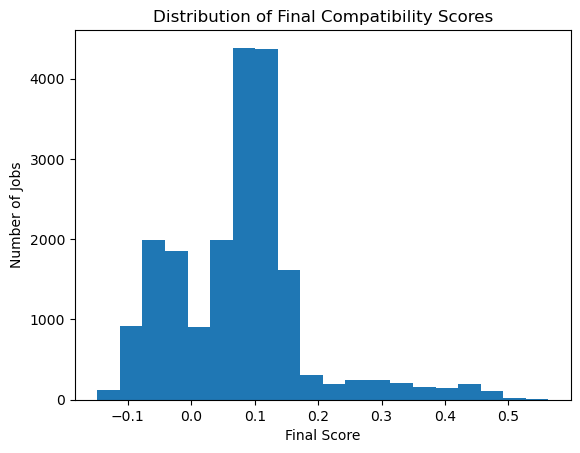

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(top_jobs["final_score"], bins=20)
plt.title("Distribution of Final Compatibility Scores")
plt.xlabel("Final Score")
plt.ylabel("Number of Jobs")
plt.show()

### Step 9: Explainable Recommendation Output

In [30]:
def generate_explanation(row):
    if row["fit_category"] == "Strong Fit":
        return "High semantic alignment and strong bidirectional skill match."
    elif row["fit_category"] == "Moderate Fit":
        return "Good alignment but some skill gaps or experience mismatch."
    else:
        return "Limited skill alignment or multiple missing required skills."

top_jobs["explanation"] = top_jobs.apply(generate_explanation, axis=1)
for i, (_, row) in enumerate(top_jobs.head(5).iterrows(), 1):
    print("Explanation:", row["explanation"])

Explanation: High semantic alignment and strong bidirectional skill match.
Explanation: High semantic alignment and strong bidirectional skill match.
Explanation: High semantic alignment and strong bidirectional skill match.
Explanation: High semantic alignment and strong bidirectional skill match.
Explanation: High semantic alignment and strong bidirectional skill match.


### Top 10 Horizontal Bar Chart
This chart visualizes the top recommended job postings ranked by final compatibility score.
It allows quick comparison between job matches and highlights which opportunities best align with the candidate profile.

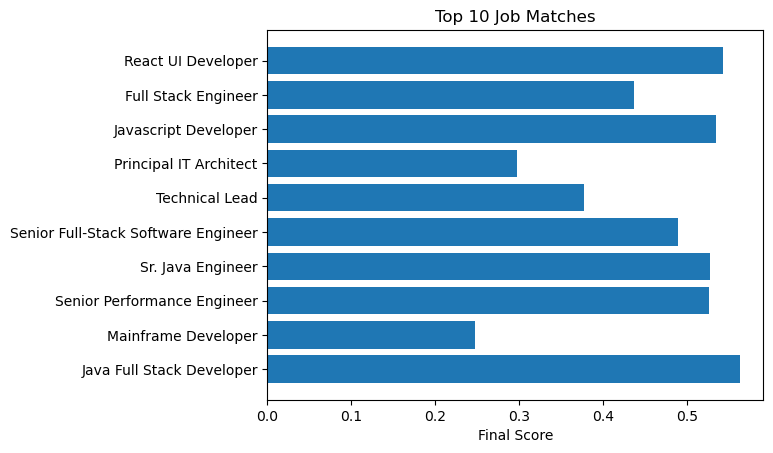

In [31]:
top10 = top_jobs.head(10)

plt.figure()
plt.barh(top10["title"], top10["final_score"])
plt.title("Top 10 Job Matches")
plt.xlabel("Final Score")
plt.gca().invert_yaxis()
plt.show()

### Step 10: Top Ranked Job Recommendations

In [32]:
# Result
for i, (_, row) in enumerate(top_jobs.head(5).iterrows(), 1):
    
    semantic_percent = round(row["semantic_score"] * 100, 1)
    resume_percent = round(row["skill_coverage"] * 100, 1)
    job_percent = round(row["job_coverage"] * 100, 1)
    dual_percent = round(((row["skill_coverage"] + row["job_coverage"]) / 2) * 100, 1)
    final_percent = round(row["final_score"] * 100, 1)

    print("\n" + "="*100)
    print(f"Rank {i} | {row['fit_category']}")
    print("-"*100)
    
    print(f"Job ID: {row['job_id']}")
    print(f"Title: {row['title']}")
    print(f"Company: {row['company_name']}")
    print(f"Location: {row['location']}")
    
    print("\nCompatibility Scores")
    print(f"   Final Score: {final_percent}%")
    print(f"   Semantic Match: {semantic_percent}%")
    print(f"   Resume to Job Match: {resume_percent}%")
    print(f"   Job to Resume Match: {job_percent}%")
    print(f"   Dual Compatibility: {dual_percent}%")
    
    print("\nSkill Analysis")
    print(f"   Skills Aligned: {', '.join(row['matched_skills'])}")
    print(f"   Resume Skills Not Used: {', '.join(row['missing_skills'])}")
    print(f"   Missing Required Skills: {', '.join(row['missing_required_skills']) if row['missing_required_skills'] else 'None'}")
    
    print("\nExplanation")
    print(f"   {row['explanation']}")
    
    print("\nApply Link")
    print(f"   {row['application_url'] if pd.notna(row['application_url']) else row['job_posting_url']}")


Rank 1 | Strong Fit
----------------------------------------------------------------------------------------------------
Job ID: 3901169389
Title: React UI Developer
Company: System Soft Technologies
Location: Dallas, TX

Compatibility Scores
   Final Score: 54.3%
   Semantic Match: 60.8%
   Resume to Job Match: 0.0%
   Job to Resume Match: 100.0%
   Dual Compatibility: 50.0%

Skill Analysis
   Skills Aligned: 
   Resume Skills Not Used: java, sql, javascript, react, node, html, css, docker
   Missing Required Skills: None

Explanation
   High semantic alignment and strong bidirectional skill match.

Apply Link
   https://www.linkedin.com/jobs/view/3901169389/?trk=jobs_biz_prem_srch

Rank 2 | Strong Fit
----------------------------------------------------------------------------------------------------
Job ID: 3902357961
Title: Full Stack Engineer
Company: TSR Consulting Services, Inc.
Location: Tampa, FL

Compatibility Scores
   Final Score: 43.7%
   Semantic Match: 59.2%
   Resume t

### Average Skill Compatability graph
This graph performs bidirectional skill analysis.
The right bar shows that the candidate satisfies most job requirements, indicating strong eligibility.
The left bar shows that many resume skills are not explicitly demanded by the jobs, suggesting potential underutilization of the candidate’s broader skillset.

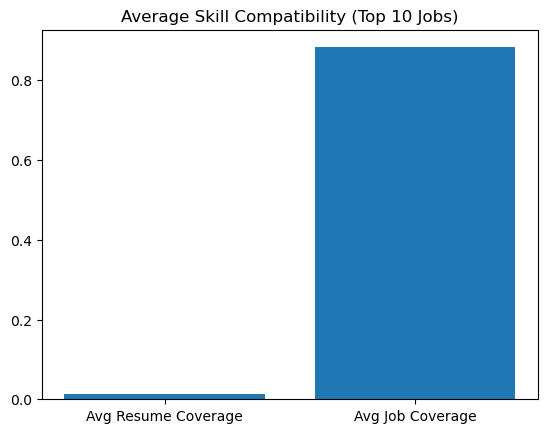

In [33]:
plt.figure()
plt.bar(
    ["Avg Resume Coverage", "Avg Job Coverage"],
    [
        top_jobs.head(10)["skill_coverage"].mean(),
        top_jobs.head(10)["job_coverage"].mean()
    ]
)
plt.title("Average Skill Compatibility (Top 10 Jobs)")
plt.show()